In [ ]:
!pip install validators
!pip install torch torchvision torchaudio
!pip install wget
#%pip uninstall --yes torch torchvision torchaudio
%pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu115
%pip install torchinfo

In [15]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision.utils as vutils
from torch.utils.data import Dataset
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid

from PIL import Image
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import warnings
import os
import cv2
import shutil
from collections import Counter
import pandas as pd
import gc
import traceback
import random
from IPython.display import HTML

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels

warnings.filterwarnings('ignore')
%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#device = torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [16]:
# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 32

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
IMAGE_SIZE = 64

# Number of training epochs
NUM_EPOCHS = 3

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for optimizers
beta1 = 0.5

# Beta2 hyperparam for optimizers
beta2 = 0.999

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [17]:
resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

resnet50.eval().to(device)

Using cache found in C:\Users\drago/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
Using cache found in C:\Users\drago/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [18]:
#DATADIR = "BeeMachine_quarter"
DATADIR = "C:/Users/drago/Documents/2022 CIS 732/Project/Cropped_Bombus/Bumble_iNat_BugGuide_BBW_BBB"

CATEGORIES = ["Bombus_affinis", "Bombus_appositus", "Bombus_auricomus", "Bombus_bifarius", "Bombus_bimaculatus", "Bombus_borealis", 
             "Bombus_caliginosus", "Bombus_centralis", "Bombus_citrinus", "Bombus_crotchii", "Bombus_cryptarum", "Bombus_fernaldae_flavidus", 
             "Bombus_fervidus_californicus", "Bombus_flavifrons", "Bombus_fraternus", "Bombus_frigidus", "Bombus_griseocollis", "Bombus_huntii", 
             "Bombus_impatiens", "Bombus_insularis", "Bombus_melanopygus", "Bombus_mixtus", "Bombus_morrisoni", "Bombus_nevadensis", 
             "Bombus_occidentalis", "Bombus_pensylvanicus_sonorus", "Bombus_perplexus","Bombus_rufocinctus", "Bombus_sandersoni",
             "Bombus_sitkensis", "Bombus_sylvicola", "Bombus_ternarius", "Bombus_terricola", "Bombus_vagans", "Bombus_vandykei", 
             "Bombus_vosnesenskii"]

Import Data

In [19]:
def load_dataset(is_simple_transform=True):
    if is_simple_transform:
        transformer = transforms.Compose([
            transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
            transforms.ToTensor(),
             transforms.Normalize([0.5],[0.5])
        ])
    else:
        transformer = transforms.Compose([
            transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
            transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.4904, 0.4515, 0.3639],
                                    std=[0.2403, 0.2280, 0.2248])
        ])
    #mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    #Load image
    dataset = datasets.ImageFolder(root=f'{DATADIR}', transform=transformer)
    return dataset

In [20]:
def find_mean_std(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=8)
    nimages = 0
    mean = 0.
    std = 0.
    for batch, _ in loader:
        # Rearrange batch to be the shape of [B, C, W * H]
        batch = batch.view(batch.size(0), batch.size(1), -1)
        # Update total number of images
        nimages += batch.size(0)
        # Compute mean and std here
        mean += batch.mean(2).sum(0) 
        std += batch.std(2).sum(0)

    # Final step
    mean /= nimages
    std /= nimages

    print(mean)
    print(std)

#find_mean_std(bee_dataset)
# mean tensor([0.4904, 0.4515, 0.3639])
# std tensor([0.2403, 0.2280, 0.2248])

In [21]:
bee_dataset = load_dataset(is_simple_transform=True)

num_classes=len(bee_dataset.targets)
train_indices, val_indices = train_test_split(list(range(num_classes)), test_size=0.2, stratify=bee_dataset.targets)
train_dataset = torch.utils.data.Subset(bee_dataset, train_indices)
val_dataset = torch.utils.data.Subset(bee_dataset, val_indices)
resnet50.fc = nn.Sequential(
               nn.Linear(2048, IMAGE_SIZE),
               nn.Dropout(p=0.02),
               nn.ReLU(inplace=True),
               nn.Linear(IMAGE_SIZE, 45),
               nn.Softmax()).to(device) 
torch.autograd.set_detect_anomaly(True)      

Create DataLoader

In [22]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
print(torch.cuda.memory_allocated(device))
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)
print(torch.cuda.memory_allocated(device))

192516608
192516608


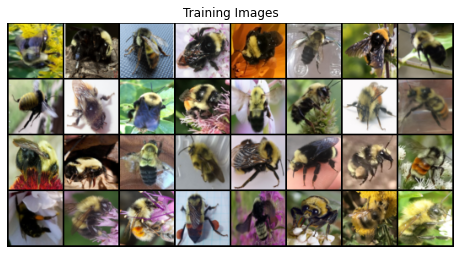

In [23]:
# Plot some training images
real_batch = next(iter(train_data_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [24]:
weights = class_weight.compute_class_weight('balanced', np.unique(bee_dataset.targets), bee_dataset.targets)
class_weights=torch.tensor(np.unique(bee_dataset.targets),dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(class_weights)
optimizer = optim.SGD(resnet50.fc.parameters(), lr=lr, momentum=beta1)

In [25]:
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataset)

def train_model(model, dataloaders, criterion, optimizer, train_loss, train_acc, total_step, num_epochs=3):
    for epoch in range(1, num_epochs+1):
        running_loss = 0.0
        correct = 0
        total=0
        model.train()
        print(f'Epoch {epoch}\n')
        for batch_idx, (data_, target_) in enumerate(dataloaders):
            data_, target_ = data_.to(device), target_.to(device)            
            outputs = model(data_)
            loss = criterion(outputs, target_)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _,pred = torch.max(outputs, dim=1)
            correct += torch.sum(pred==target_).item()
            total += target_.size(0)
            #print("matrix predict {} target {}".format(pred, target_))
            if (batch_idx) % 20 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch, num_epochs, batch_idx * batch_size, total_step, loss.item()))
        train_acc.append(100 * correct / total)
        train_loss.append(running_loss/total_step)
        print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
        
        validate_model(model, val_data_loader, valid_loss_min, val_loss, val_acc)
                  
    return model

In [26]:
def validate_model(model, dataloaders, valid_loss_min, val_loss, val_acc):
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_, target_ in dataloaders:
            data_t, target_t = data_.to(device), target_.to(device)
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            #print("predict {} target {}".format(len(pred_t), len(target_t)))
            #print("matrix predict {} target {}".format(pred_t, target_t))
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(dataloaders))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')
        
        if network_learned:
            modelPath = 'models/pytorch'
            isExist = os.path.exists(modelPath)
            if not isExist:
                # Create a new directory because it does not exist 
                os.makedirs(modelPath)
                print("The new directory {} is created!".format(modelPath))
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'models/pytorch/traiend_resnet50.h5')
            print('Improvement-Detected, save-model')

In [27]:
def show_confusion_matrix(model, labels, pred_labels):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

In [28]:
try:
    model_trained = train_model(resnet50, train_data_loader, criterion, optimizer, train_loss, train_acc, total_step, NUM_EPOCHS)
except Exception:
    print(traceback.format_exc())
    print(torch.cuda.memory_summary(device=None, abbreviated=False))

Epoch 1

Epoch [1/3], Step [0/31848], Loss: 3.8057
Epoch [1/3], Step [640/31848], Loss: 3.8053
Epoch [1/3], Step [1280/31848], Loss: 3.8056
Epoch [1/3], Step [1920/31848], Loss: 3.8061
Epoch [1/3], Step [2560/31848], Loss: 3.8064
Epoch [1/3], Step [3200/31848], Loss: 3.8046
Epoch [1/3], Step [3840/31848], Loss: 3.8069
Epoch [1/3], Step [4480/31848], Loss: 3.8057
Epoch [1/3], Step [5120/31848], Loss: 3.8059
Epoch [1/3], Step [5760/31848], Loss: 3.8053
Epoch [1/3], Step [6400/31848], Loss: 3.8073
Epoch [1/3], Step [7040/31848], Loss: 3.8055
Epoch [1/3], Step [7680/31848], Loss: 3.8060
Epoch [1/3], Step [8320/31848], Loss: 3.8062
Epoch [1/3], Step [8960/31848], Loss: 3.8063
Epoch [1/3], Step [9600/31848], Loss: 3.8067
Epoch [1/3], Step [10240/31848], Loss: 3.8068
Epoch [1/3], Step [10880/31848], Loss: 3.8064
Epoch [1/3], Step [11520/31848], Loss: 3.8062
Epoch [1/3], Step [12160/31848], Loss: 3.8045
Epoch [1/3], Step [12800/31848], Loss: 3.8043
Epoch [1/3], Step [13440/31848], Loss: 3.8059

In [30]:
from IPython import display

# kill error when executing argparse in IPython console
import sys; sys.argv=['']; del sys

In [31]:
import argparse
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import sklearn.metrics as sm

# parse arguments
parser = argparse.ArgumentParser(description='Imbalanced Dataset Example')
parser.add_argument('--data', metavar='DIR', default='./data/oven', help='path to dataset')
parser.add_argument('--arch', '-a', metavar='ARCH', default='resnet18')
parser.add_argument('--epochs', default=90, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('-b', '--batch-size', default=256, type=int,
                    metavar='N', help='mini-batch size (default: 256)')
parser.add_argument('--lr', '--learning-rate', default=0.1, type=float,
                    metavar='LR', help='initial learning rate')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                    help='momentum')
parser.add_argument('--weight-decay', '--wd', default=1e-4, type=float,
                    metavar='W', help='weight decay (default: 1e-4)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=42, metavar='S',
                    help='random seed (default: 42)')
args = parser.parse_args()

use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")
#device = torch.device("cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [32]:
def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight  

In [36]:
import torch 
dataset_train = bee_dataset       
                                                                             
# For unbalanced dataset we create a weighted sampler                       
weights = make_weights_for_balanced_classes(dataset_train.imgs, len(dataset_train.classes))                                                                
weights = torch.DoubleTensor(weights)                                       
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))                     
                                                                                
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=args.batch_size, shuffle = False,                              
                                                             sampler = sampler, num_workers=4, pin_memory=True)  
train_data_loader  = train_loader

In [37]:
#weights = class_weight.compute_class_weight(
#    'balanced', np.unique(training_list), training_list)
class_weights = torch.tensor(weights, dtype=torch.float).to(device)

#criterion = nn.CrossEntropyLoss(class_weights)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.fc.parameters(), lr=0.0001, momentum=0.9)

In [38]:
Oversample = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')
Oversample.eval().to(device)

Using cache found in C:\Users\drago/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
Using cache found in C:\Users\drago/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [39]:
try:
    model_trained = train_model(Oversample, train_data_loader, criterion, optimizer, train_loss, train_acc, total_step, NUM_EPOCHS)
except Exception:
    print(traceback.format_exc())
    print(torch.cuda.memory_summary(device=None, abbreviated=False))

Epoch 1

Epoch [1/3], Step [0/31848], Loss: 13.2929
Epoch [1/3], Step [640/31848], Loss: 12.8827
Epoch [1/3], Step [1280/31848], Loss: 13.2661
Epoch [1/3], Step [1920/31848], Loss: 12.8985
Epoch [1/3], Step [2560/31848], Loss: 13.4898
Epoch [1/3], Step [3200/31848], Loss: 13.2706
Epoch [1/3], Step [3840/31848], Loss: 13.4078
Epoch [1/3], Step [4480/31848], Loss: 13.3437

train-loss: 0.1053, train-acc: 0.1206
validation loss: 6.1856, validation acc: 0.1005

Improvement-Detected, save-model
Epoch 2

Epoch [2/3], Step [0/31848], Loss: 13.2692
Epoch [2/3], Step [640/31848], Loss: 13.5344
Epoch [2/3], Step [1280/31848], Loss: 12.7003
Epoch [2/3], Step [1920/31848], Loss: 13.2007
Epoch [2/3], Step [2560/31848], Loss: 13.3484
Epoch [2/3], Step [3200/31848], Loss: 13.1465
Epoch [2/3], Step [3840/31848], Loss: 13.2244
Epoch [2/3], Step [4480/31848], Loss: 13.2603

train-loss: 0.0969, train-acc: 0.1080
validation loss: 7.5580, validation acc: 0.1005

Improvement-Detected, save-model
Epoch 3

Epo

try different model

In [55]:
train_loader = train_data_loader
test_loader = val_data_loader

In [ ]:

def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = args.lr * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def process(train_loader, test_loader):
    
    model = torchvision.models.__dict__[args.arch]()
    if args.arch.startswith('alexnet') or args.arch.startswith('vgg'):
        model.features = torch.nn.DataParallel(model.features)
        model.cuda()
    else:
        model = torch.nn.DataParallel(model).cuda()

    # define loss function (criterion) and optimizer
    criterion = torch.nn.CrossEntropyLoss().cuda()
    optimizer = torch.optim.SGD(model.parameters(), args.lr,
                                momentum=args.momentum,
                                weight_decay=args.weight_decay)

    # train & test process
    def train(train_loader):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):            
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            print('\rTraining       %d/%d' % (batch_idx + 1, len(train_loader)), end='', flush=True)

    def test(test_loader):
        model.eval()
        correct = 0
        targets, preds = [], []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
                
                targets += list(target.cpu().numpy())
                preds += list(pred.cpu().numpy())

        test_acc = 100. * correct / len(test_loader.dataset)
        confusion_mtx = sm.confusion_matrix(targets, preds)
        return test_acc, confusion_mtx
    
    test_accs, confusion_mtxes = [], []    
    for epoch in range(1, args.epochs + 1):
        adjust_learning_rate(optimizer, epoch)
        train(train_data_loader)
        test_acc, confusion_mtx = test(test_loader)
        test_accs.append(test_acc)
        confusion_mtxes.append(confusion_mtx)
        print('\rBest test acc = %2.2f%%' % max(test_accs), end='', flush=True)
        
    vis(test_accs, confusion_mtxes, classe_labels)

Dataset: 31848 training samples & 7962 testing samples

Distribution of classes in dataset:


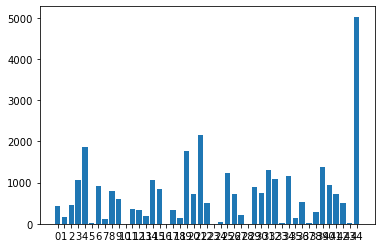

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
        
!pip install seaborn
import seaborn as sns

print('Dataset: %d training samples & %d testing samples\n' % (
   len(train_loader.dataset), len(test_loader.dataset)))
 
print('Distribution of classes in dataset:')
fig, ax = plt.subplots()
labels = [label for _, label in train_loader.dataset]
classe_labels, counts = np.unique(labels, return_counts=True)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.show()

def vis(test_accs, confusion_mtxes, labels, figsize=(20, 8)):
    
    cm = confusion_mtxes[np.argmax(test_accs)]
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%' % p
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    
    fig = plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.plot(test_accs, 'g')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=annot, fmt='', cmap="Blues")
    plt.show()

In [ ]:
process(train_loader, test_loader)


Training 922/99649.13%